In [ ]:
import numpy as np
import os
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K

In [ ]:
!cp '/content/drive/MyDrive/datasets/TomatoDataset_Min1 (2).zip' '/content/TomatoDataset_Min1.zip'

In [ ]:
!unzip '/content/TomatoDataset_Min1.zip'

In [ ]:
INIT_LR = 1e-3
BATCH_SIZE = 16
EPOCHS = 100
IMAGE_SIZE = 256
default_image_size = tuple((IMAGE_SIZE, IMAGE_SIZE))
image_size = 0
data_dir = "/content/TomatoDataset_Min1"
CHANNELS=3
AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
!rm -rf '/content/TomatoDataset_Min1/.ipynb_checkpoints'

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = ds.cardinality().numpy()
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  seed=123,
  image_size=default_image_size,
  batch_size=BATCH_SIZE
)


train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

Found 1008 files belonging to 11 classes.


In [ ]:
class_names = dataset.class_names
n_classes = len(class_names)
print(n_classes, class_names)

11 ['BacterialSpot', 'EarlyBlight', 'Healthy', 'LateBlight', 'LeafMold', 'MosaicVirus', 'Others', 'SeptoriaLeaf', 'SpiderMites', 'TargetSpot', 'YellowLeaf']


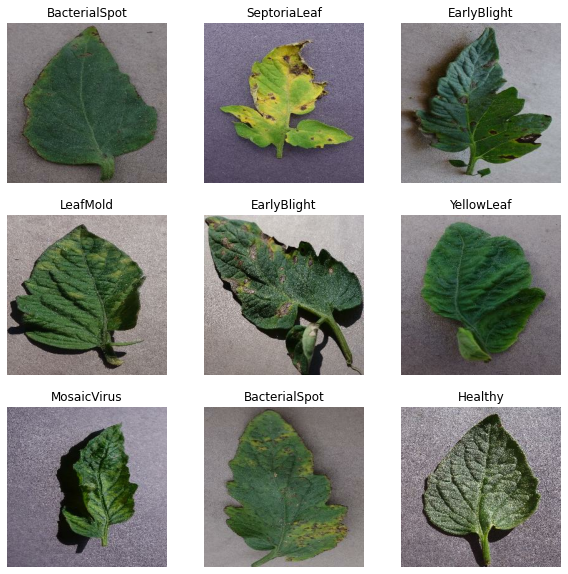

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(16, 256, 256, 3)
(16,)


In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
batch_input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
chanDim = -1
if K.image_data_format() == "channels_first":
    input_shape = (CHANNELS, IMAGE_SIZE, IMAGE_SIZE)
    batch_input_shape = (BATCH_SIZE, CHANNELS, IMAGE_SIZE, IMAGE_SIZE)
    chanDim = 1

In [ ]:
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=batch_input_shape)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (16, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (16, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (16, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (16, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (16, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (16, 62, 62, 64)         0         
 2D)                                                  

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)
# tf.keras.metrics.Precision(), tf.keras.metrics.Recall()

In [ ]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/100
50/50 [==============================] - 98s 2s/step - loss: 2.3508 - accuracy: 0.0925 - val_loss: 2.4569 - val_accuracy: 0.1146
Epoch 2/100
50/50 [==============================] - 91s 2s/step - loss: 2.3303 - accuracy: 0.0763 - val_loss: 2.4392 - val_accuracy: 0.0625
Epoch 3/100
50/50 [==============================] - 97s 2s/step - loss: 2.3113 - accuracy: 0.1225 - val_loss: 2.4078 - val_accuracy: 0.1042
Epoch 4/100
50/50 [==============================] - 92s 2s/step - loss: 2.3495 - accuracy: 0.0950 - val_loss: 2.4040 - val_accuracy: 0.1042
Epoch 5/100
50/50 [==============================] - 92s 2s/step - loss: 2.3417 - accuracy: 0.1025 - val_loss: 2.3853 - val_accuracy: 0.0521
Epoch 6/100
50/50 [==============================] - 94s 2s/step - loss: 2.3423 - accuracy: 0.0913 - val_loss: 2.3774 - val_accuracy: 0.0833
Epoch 7/100
50/50 [==============================] - 93s 2s/step - loss: 2.3398 - accuracy: 0.0925 - val_loss: 2.3719 - val_accuracy: 0.1250
Epoch 8/100
5

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


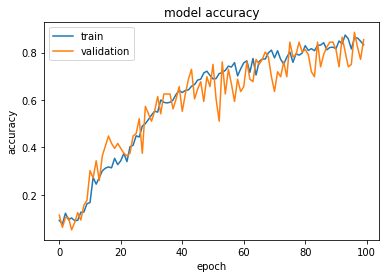

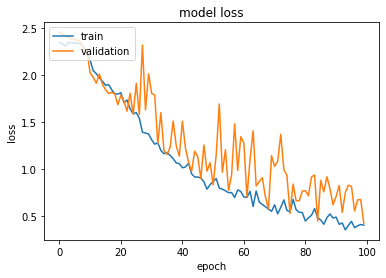

In [29]:
from matplotlib import pyplot as plt
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [25]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(test_ds)
print(f"Test Accuracy: {round(scores[1],4)*100}%")

[INFO] Calculating model accuracy
7/7 [==============================] - 3s 437ms/step - loss: 0.3994 - accuracy: 0.8661
Test Accuracy: 86.61%


In [ ]:
import os
model.save("CNN.h5")

In [30]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

first image to predict
actual label: SeptoriaLeaf
1/1 [==============================] - 0s 440ms/step
predicted label: SeptoriaLeaf


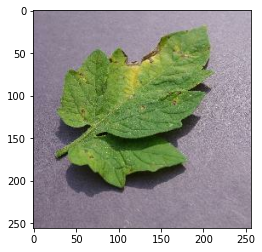

In [34]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [35]:
!pip install --upgrade tensorflow-model-optimization
import tensorflow_model_optimization as tfmot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.9/238.9 KB 18.8 MB/s eta 0:00:00


In [36]:
def apply_quantization(layer):
    if (
        isinstance(layer, layers.Dense)
        or isinstance(layer, layers.MaxPool2D)
        or isinstance(layer, layers.Conv2D)
    ):
        return tfmot.quantization.keras.quantize_annotate_layer(layer)
    return layer

In [37]:
annotated_model = tf.keras.models.clone_model(
    model,
    clone_function=apply_quantization,
)

quant_aware_model = tfmot.quantization.keras.quantize_apply(annotated_model)
quant_aware_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 quant_conv2d (QuantizeWrapp  (None, 254, 254, 32)     963       
 erV2)                                                           
                                                                 
 quant_max_pooling2d (Quanti  (None, 127, 127, 32)     1         
 zeWrapperV2)                                                    
                                                                 
 quant_conv2d_1 (QuantizeWra  (None, 125, 125, 64)     18627     
 pperV2)                                                         
                                                      

In [38]:
quant_aware_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [39]:
q_history = quant_aware_model.fit(train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=25,
)

Epoch 1/25
50/50 [==============================] - 112s 2s/step - loss: 0.5204 - accuracy: 0.7975 - val_loss: 0.7607 - val_accuracy: 0.8021
Epoch 2/25
50/50 [==============================] - 107s 2s/step - loss: 0.4417 - accuracy: 0.8475 - val_loss: 0.8362 - val_accuracy: 0.8229
Epoch 3/25
50/50 [==============================] - 105s 2s/step - loss: 0.4951 - accuracy: 0.8175 - val_loss: 0.6699 - val_accuracy: 0.8333
Epoch 4/25
50/50 [==============================] - 105s 2s/step - loss: 0.3630 - accuracy: 0.8750 - val_loss: 0.7987 - val_accuracy: 0.7917
Epoch 5/25
50/50 [==============================] - 107s 2s/step - loss: 0.4366 - accuracy: 0.8350 - val_loss: 0.7328 - val_accuracy: 0.7812
Epoch 6/25
50/50 [==============================] - 107s 2s/step - loss: 0.4299 - accuracy: 0.8425 - val_loss: 0.7329 - val_accuracy: 0.7812
Epoch 7/25
50/50 [==============================] - 110s 2s/step - loss: 0.3737 - accuracy: 0.8612 - val_loss: 0.6474 - val_accuracy: 0.8750
Epoch 8/25
50

In [40]:
import os
model.save("FineTuning.h5")

In [41]:
converter = tf.lite.TFLiteConverter.from_keras_model(quant_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

quantized_tflite_model = converter.convert()

/usr/local/lib/python3.8/dist-packages/tensorflow/lite/python/convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


In [42]:
import tensorflow as tf

model = tf.keras.models.load_model('/content/FineTuning.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open("converted_model.tflite", "wb").write(tflite_model)

743740

In [43]:
import cv2

interpreter = tf.lite.Interpreter(model_path="/content/converted_model.tflite")
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
interpreter.allocate_tensors()
print(input_details[0]['dtype'])
    
    # lectura y procesamiento de imagen
img = cv2.imread("/content/TomatoDataset_Min1/LeafMold/0a555f63-bf03-4958-8993-e1932b8dce9f___Crnl_L.Mold 9064.JPG")
new_img = cv2.resize(img, (256, 256))
new_img = new_img.astype(np.float32)
new_img /= 255.
  
# input_details[0]['index'] = the index which accepts the input
interpreter.set_tensor(input_details[0]['index'], [new_img])
    
# realizar la prediccion del interprete
interpreter.invoke()
    
    # output_details[0]['index'] = the index which provides the input
output_data = interpreter.get_tensor(output_details[0]['index'])
    
print("the output is {}".format(output_data))

<class 'numpy.float32'>
the output is [[1.8723228e-25 9.9124929e-07 0.0000000e+00 9.9999905e-01 3.5293378e-17
  0.0000000e+00 0.0000000e+00 4.1277227e-18 0.0000000e+00 0.0000000e+00
  3.2708013e-22]]


In [44]:
def evaluate_tflite_model (dataset, interpreter):
    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]

    prediction_digits = []
    test_labels = []
    for image, label in dataset.unbatch().take(dataset.unbatch().cardinality()):

        test_image = np.expand_dims(image, axis=0).astype(np.float32)
        interpreter.set_tensor(input_index, test_image)
        interpreter.invoke()
        
        output = interpreter.tensor(output_index)
        digit = np.argmax(output()[0])
        prediction_digits.append(digit)
        test_labels.append(label)

    prediction_digits = np.array(prediction_digits)
    accuracy = (prediction_digits == test_labels).mean()
    return accuracy
interpreter = tf.lite.Interpreter(model_content=quantized_tflite_model)
interpreter.allocate_tensors()

test_accuracy = evaluate_tflite_model(dataset, interpreter)

print('Quant TFLite test_accuracy:', test_accuracy)

Quant TFLite test_accuracy: 0.7767857142857143


In [ ]:
import os
model.save("tflite_model.pb")

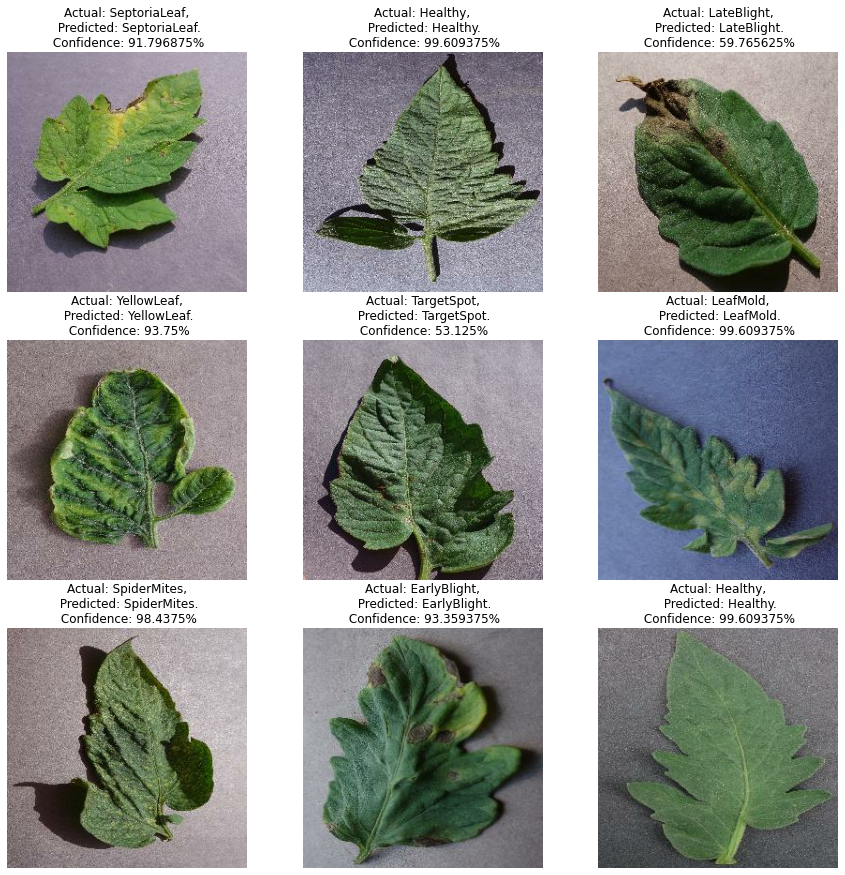

In [45]:
input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))        

        actual_class = class_names[labels[i]]

        test_image = np.expand_dims(images[i], axis=0).astype(np.float32)
        interpreter.set_tensor(input_index, test_image)
        interpreter.invoke()
        output = interpreter.tensor(output_index)
        digit = np.argmax(output()[0])

        predicted_class = class_names[digit]
        confidence = np.max(output()[0])*100

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")